# Consistent Hashing

In [1]:
import hashlib
from bisect import bisect, bisect_left, bisect_right
from typing import Union

import matplotlib.pyplot as plt

In [2]:
def plot_hashring(hash_space, occupied_keys, item_key: int = None, node_key: int = None):
    figure = plt.figure()
    axes_1 = figure.add_axes([0, 0, 3, 1])
    axes_1.axes.get_yaxis().set_visible(False)
    plt.ylim(top=2)
    y_data = [0] * hash_space
    for k in occupied_keys:
        y_data[k] = 1

    if item_key:
        y_data[item_key] = 0.75

    barlist = axes_1.bar(range(hash_space), y_data)

    if item_key is not None:
        barlist[item_key].set_color('r')
    
    if node_key is not None:
        barlist[node_key].set_color('g')

    plt.show()

In [3]:
def hash_fn(data: str) -> int:
    """hash_fn creates an integer equivalent of a SHA256 hash

    data could be a string or an integer
    """
    hsh = hashlib.sha256()

    # converting data into bytes and passing it to hash function
    hsh.update(bytes(data.encode('utf-8')))

    # converting the HEX digest into equivalent integer value
    return int(hsh.hexdigest(), 16)

In [4]:
class HashRing:
    """HashRing represents Consistent HashRing. One instance of this
    class will be one instance of Consistent HashRing. The class exposes
    all the functions required to interact with the ring.
    """

    def __init__(self):
        self._keys = []          # indices taken up in the ring
        self.nodes = []          # nodes present in the ring. nodes[i] is present at index keys[i]
        self.hash_space = 100    # total slots in the ring

    def _generate_key(self, data):
        """returns hash key modulo hash_space because of which it represents
        the location in the flattened hash ring where the data should reside.
        """
        if not data:
            return None
        return hash_fn(data) % self.hash_space

    def add_node(self, node_id: str) -> int:
        """add_node function adds a new node to the ring and returns the key
        from the hash space where it was placed
        """

        # handling error when hash space is full.
        if len(self._keys) == self.hash_space:
            raise Exception("hash space is full")

        key = self._generate_key(node_id)

        # find the index where the key should be inserted in the keys store
        index = bisect(self._keys, key)

        # if we have already seen the key i.e. node already is present
        # for the same key, we raise Collision Exception
        if index > 0 and self._keys[index - 1] == key:
            raise Exception("collision occurred")

        # insert the node_id and the key at the same `index` location.
        # this insertion will keep nodes and keys sorted w.r.t keys.
        self.nodes.insert(index, node_id)
        self._keys.insert(index, key)

        return key

    def remove_node(self, node_id: str) -> int:
        """remove_node removes the node with id = node_id and returns the key
        from the hash space on which the node was placed.
        """

        # handling error when space is empty
        if len(self._keys) == 0:
            raise Exception("hash space is empty")

        key = hash_fn(node_id) % self.hash_space

        # we find the index where the key would reside in the keys
        index = bisect_left(self._keys, key)

        # if key does not exist in the array we raise Exception
        if index >= len(self._keys) or self._keys[index] != key:
            raise Exception("node does not exist")

        # now that all sanity checks are done we popping the
        # keys and nodes at the index and thus removing presence of the node.
        self._keys.pop(index)
        self.nodes.pop(index)

        return key

    def assign(self, item_id: str) -> str:
        """Given an item, the function returns the node_id through which this
        item will be served.
        """
        key = self._generate_key(item_id)

        # we find the first right node to this key
        # if bisect_right returns index which is out of bounds then
        # we circle back to the first in the array - making it a ring
        index = bisect_right(self._keys, key) % len(self._keys)

        # return the node present at the index
        return self.nodes[index]

    def plot(self, item_id: str = None, node_id: str = None) -> None:
        plot_hashring(
            self.hash_space,
            self._keys,
            item_key=self._generate_key(item_id),
            node_key=self._generate_key(node_id),
        )

node 1 15
node 2 61
item a 99
node assigned for a 1
item c 58
node assigned for c 2


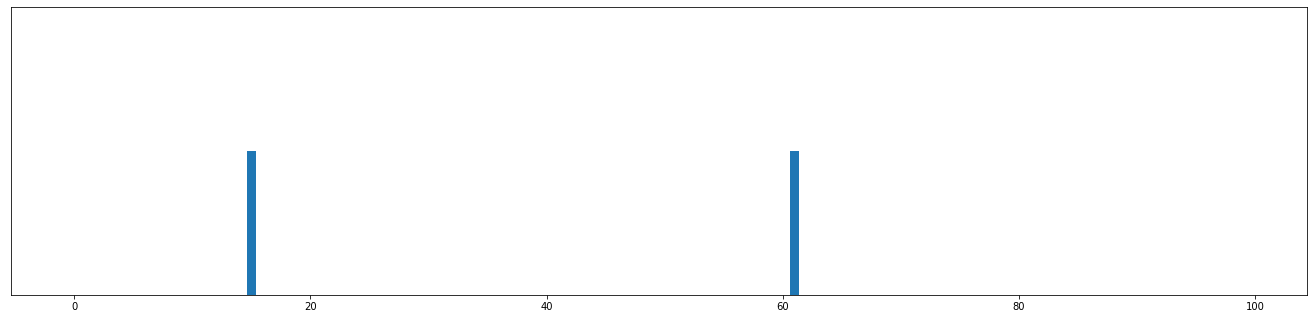

In [5]:
hr = HashRing()
print("node 1", hr.add_node("1"))
print("node 2", hr.add_node("2"))
print("item a", hr._generate_key("a"))
print("node assigned for a", hr.assign("a"))
print("item c", hr._generate_key("c"))
print("node assigned for c", hr.assign("c"))
hr.plot()